# CAIM Lab Session 5: Duplicate detection using simhash

In this session you will:

- implement the simhashing algorithm
- apply it to the `arxiv` abstracts to detect near duplicates among documents in this index

## 1. Simhash-based near-duplicate detection algorithm

We depart from an indexed corpus, namely the one that we have used in previous sessions that contains 58102 abstracts from the
scientific [arXiv.org](https://arxiv.org) repository. The following pseudocode uses $k,m$ as the usual parameters for lsh (locality sensitive hashing)
scheme for gap amplification (repetition of $m$ lsh tables, using $k$ projections each).

  1. For each word $t$ in the vocabulary $V$ we generate $b = k\times m$ random $\pm 1$ signs:
      - generate a unique hash (bitstring) $h_t$ of size $b$
      - let $h'_t$ be the hash above but replacing each 0 with -1.
  
  2. We view each document as a tf-idf weighted sum of its terms. Thus, to hash a document, we sum the weighted contributions of all its terms. Specifically, for each document in our corpus represented by list of non-zero entries $t, w_t$:
      - compute $simhash(d)$ as sum $\sum_t h'_t * w_t$. 
      - convert $simhash(d)$ to bit vector using the sign of entries (positive entries become 1, negative ones become 0)
  
  3. Slice simhashes into $m$ chunks of $k$ bits
     - for each $k$-bit chunk:
        - place the document into the bucket given by the chunk in the appropriate table. Note that we may identify each chunk with an integer index between 0 and 2^k - 1.
  
  4. Similar documents will likely fall on the same side of many hyperplanes, and thus share one or more $k$-bit chunks. Thus, the potential duplicates are pairs of documents that fall into the same bucket in **at least one** hash table. Now we need to
     - compute cosine similarity among these potential duplicates, and
     - show pairs in decreasing cosine similarity order.


---

**Exercise 1:**  

As a little exercise, suppose that a document $d$ contains _two_ non-zero entries, which correspond to terms `bit` with tf-idf weight $0.4$ and `coin` with tf-idf weight $1.2$.
The md5 hash code for `bit` is 1111 and the md5 code for `coin` is 1001 (so $b=4$). Compute the binary simhash for this document with $k=4, m = 1$. (_Hint: result should be 1001_)

---

Vamos a calcular el simhash de un documento que contiene dos términos: `bit` con peso tf-idf 0.4 y `coin` con peso tf-idf 1.2. Los hashes md5 son 1111 para `bit` y 1001 para `coin`.

| Term | peso tf-idf   | md5 hash (4 bits) | ( h'_t ) (reemplazar 0 con -1)            |
| ---- | ------------- | ----------------- | ----------------------------------------- |
| bit  | 0.4           | 1111              | ([1, 1, 1, 1] --> [1,  1,  1, 1])         |
| coin | 1.2           | 1001              | ([1, 0, 0, 1] --> [1, -1, -1, 1])         |

Por lo tanto la _weighted sum_ es:

$$
simhash(d) = 0.4 * [1, 1, 1, 1] + 1.2 * [1, -1, -1, 1] = [1.6, -0.8, -0.8, 1.6]
$$

Ahora convertimos esta suma en un vector binario usando el signo de las entradas:

$$
simhash(d) = [1, 0, 0, 1]
$$

En este ejercicio se muestra manualmente cómo se calcula el vector simhash de un documento a partir de los hashes de sus términos y sus pesos tf-idf. Se obtiene una representación binaria que refleja en qué lado del hiperplano cae el documento respecto a las proyecciones aleatorias. El resultado [1, 0, 0, 1] indica la huella binaria final, que sirve como representación compacta y eficiente para detectar similitud entre documentos.

## 2. Hashing codes for terms in vocabulary

To make your life easier, we provide code for generating hash codes for the terms in the vocabulary.
The given function takes as input the size of the hash, as well as the term itself.

We use a fast deterministic hash (MD5) to get repeatable pseudo-random bits. Even though it is actually deterministic, we assume that in practice its output behaviour is sufficiently similar to that of a truly random hash function.

In [1]:
import hashlib

def _termhash(x : str, b : int) -> str:
    """returns bitstring of size b based on md5 algorithm"""
    assert b <= 128, 'this encoding scheme supports hashes of length at most 128; try smaller b'
    h = hashlib.md5(x.encode('utf8')).digest()
    return ''.join(format(byte, '08b') for byte in h)[:b]

for w in ['bit', 'coin', 'hola que tal']:
    print(f'hash.md5({w}) = {_termhash(w, 4)}')


hash.md5(bit) = 1111
hash.md5(coin) = 1001
hash.md5(hola que tal) = 0110


## 3. Loading tf-idf for the whole corpus

We provide the document-term matrix with normalized tf-idf weights with a sparse representation.
This is so that further code does not need to check for tf-idf weights against elasticsearch which is very slow.

Please download the corpus data from https://www.cs.upc.edu/~caim/05corpus.pkl and run the following cells to access the data.

In [2]:
import pickle
import os

fname = '05corpus.pkl'

with open(fname, 'rb') as f:
    corpus = pickle.load(f)

### have a look at the data

Loaded corpus with 58102 documents.
A few document ids are: ['17437', '22023', '24126', '26928', '29425', '3585', '3694', '41179', '45962', '46970']
Each document is a dictionary with term -> tf-idf weights, e.g. the first:
{'0.009': np.float64(0.07755241277245155), '0.03': np.float64(0.05390282783916337), '2.3': np.float64(0.05697594345388175), '3': np.float64(0.037520471487291714), '6': np.float64(0.06263176984143355), '8': np.float64(0.03381614985233684), 'aboard': np.float64(0.07470497254146928), 'abridged': np.float64(0.04658961411040711), 'absence': np.float64(0.04085137050637872), 'accretion': np.float64(0.07414988654879776), 'acquire': np.float64(0.05537897824225455), 'also': np.float64(0.009403647100788688), 'area': np.float64(0.03366260253470469), 'assembled': np.float64(0.05973338041851722), 'balmer': np.float64(0.06406254101592618), 'based': np.float64(0.011164937538935934), 'because': np.float64(0.027935714599668877), 'below': np.float64(0.03351983591805465), 'beta': np.fl

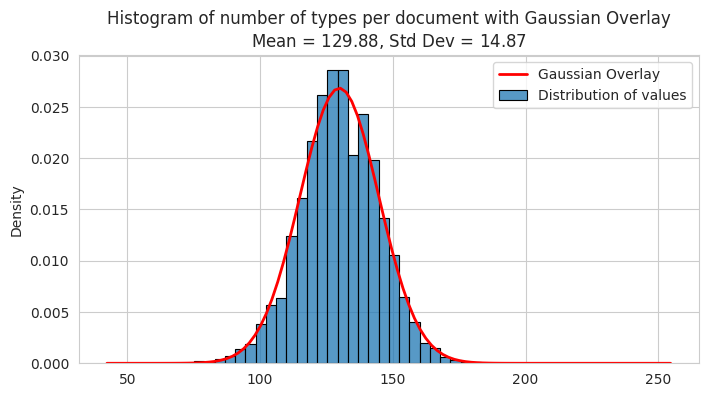

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import random

# show contents

print(f"Loaded corpus with {len(corpus)} documents.")
all_document_ids = list(corpus.keys())
print(f"A few document ids are: {sorted(random.sample(all_document_ids, 10))}")
print(f"Each document is a dictionary with term -> tf-idf weights, e.g. the first:")
print(corpus[all_document_ids[0]])

# obtain histogram with nr of terms in each document
values = [len(corpus[id]) for id in all_document_ids]
mu = np.mean(values)
sigma = np.std(values)
plt.figure(figsize=(8, 4))
sns.set_style("whitegrid")
sns.histplot(values, bins=50, edgecolor='black', stat='density', label='Distribution of values')
plt.title(f'Histogram of number of types per document with Gaussian Overlay\nMean = ${mu:.2f}$, Std Dev = ${sigma:.2f}$', fontsize=12)
xmin, xmax = plt.xlim()
x_axis = np.linspace(xmin, xmax, 100)

# Calculate the probability density function (PDF) for the x-values.
plt.plot(x_axis, norm.pdf(x_axis, mu, sigma), 'red', linewidth=2, label='Gaussian Overlay')
plt.legend(); # Display the labels

## 4. Simhashing scheme and near-duplicate collection and verification

---

**Exercise 2:**  

Write the `simhash` function provided below. Make sure you understand that each bit of the simhash encodes which "side" the tf-idf document representation falls on a (pseudo-)random projection. 


---


In [4]:
from tqdm import tqdm

## constants
K = 18
M = 3
B = M*K

def _simhash(id, b):
    """
        id is the document id, b is the desired length of the simhash
        it should return a bitstring of length b as explained in the
        first section of the notebook
    """
    doc = corpus[id]
    simhash_vector = np.zeros(b)
    
    # For each term in the document
    for term, weight in doc.items():
        hash_bits = _termhash(term, b)
        h_prime = np.array([1 if bit == '1' else -1 for bit in hash_bits])
        simhash_vector += h_prime * weight
    
    binary_simhash = ''.join(['1' if val > 0 else '0' for val in simhash_vector])    
    return binary_simhash

## simhash stores all simhashes of the whole corpus in a dictionary
simhash = {id: _simhash(id, B) for id in tqdm(corpus)}

  0%|          | 0/58102 [00:00<?, ?it/s]

100%|██████████| 58102/58102 [01:16<00:00, 757.47it/s]


Esta función implementa el cálculo automático del vector simhash a partir de las representaciones tf-idf. Para cada término del documento, se genera un hash binario de longitud b que se convierte a una representación ±1. Luego, se pondera por su peso tf-idf y se acumula la suma por cada dimensión del hash. Finalmente, se aplica la función signo para obtener el vector binario final (1 si el valor es positivo, 0 si es negativo). Este proceso convierte la representación de alta dimensión de un documento en una firma binaria de tamaño fijo que preserva la similitud semántica.

---

**Exercise 3:**  

Based on simhashes, write code that places the documents in their corresponding lsh hash tables' buckets across $m$ repetitions. Once, the lsh hash tables have been
populated, find all potential near-duplicate candidate pairs. Check among all candidates their real cosine similarity and based on this determine true positives
(pairs of documents that are indeed similar and have collided in some table), and false positives (pairs of documents that are not similar but have collided in some table).
Compute speed of the method vs. false positives / true positives for different values of $m$ and $k$. Make sure that $k$ is not tiny (say greater than 10) if you want
the method to be fast.

---


In [5]:
from collections import defaultdict
from itertools import combinations
import time

def cosine_similarity(id1, id2):
    """Compute cosine similarity between two documents using their tf-idf representations"""
    doc1 = corpus[id1]
    doc2 = corpus[id2]
    
    common_terms = set(doc1.keys()) & set(doc2.keys())
    
    dot_product = sum(doc1[term] * doc2[term] for term in common_terms)
    
    norm1 = np.sqrt(sum(w**2 for w in doc1.values()))
    norm2 = np.sqrt(sum(w**2 for w in doc2.values()))
    
    if norm1 == 0 or norm2 == 0:
        return 0.0
    
    return dot_product / (norm1 * norm2)

def lsh_buckets(k, m):
    """
    Create LSH hash tables and find candidate pairs
    k: number of bits per chunk
    m: number of hash tables (repetitions)
    """
    b = k * m
    
    # Create m hash tables, each with buckets indexed by k-bit chunks
    hash_tables = [defaultdict(list) for _ in range(m)]
    
    # Place documents into buckets
    for doc_id in corpus.keys():
        # Get or compute simhash for this document
        if doc_id in simhash and len(simhash[doc_id]) == b:
            sh = simhash[doc_id]
        else:
            sh = _simhash(doc_id, b)
        
        # Split into m chunks of k bits
        for table_idx in range(m):
            start = table_idx * k
            end = start + k
            chunk = sh[start:end]
            
            # Convert chunk to integer for bucket indexing
            bucket_id = int(chunk, 2)
            hash_tables[table_idx][bucket_id].append(doc_id)
    
    # Find candidate pairs (documents that share at least one bucket)
    candidates = set()
    for table in hash_tables:
        for bucket_id, doc_list in table.items():
            if len(doc_list) > 1:
                # All pairs in this bucket are candidates
                for pair in combinations(sorted(doc_list), 2):
                    candidates.add(pair)
    
    return candidates, hash_tables

# Test with current K and M values
print(f"Running LSH with k={K}, m={M}, b={B}")
start_time = time.time()

candidates, hash_tables = lsh_buckets(K, M)
lsh_time = time.time() - start_time

print(f"LSH computation time: {lsh_time:.2f} seconds")
print(f"Number of candidate pairs found: {len(candidates)}")

# Compute cosine similarities for candidates
print("\nComputing cosine similarities for candidates...")
start_time = time.time()

similarities = {}
for id1, id2 in tqdm(list(candidates)):
    similarities[(id1, id2)] = cosine_similarity(id1, id2)

similarity_time = time.time() - start_time
print(f"Similarity computation time: {similarity_time:.2f} seconds")

# Sort by similarity (descending)
sorted_pairs = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# Analyze results with different thresholds
threshold = 0.8
true_positives = [(pair, sim) for pair, sim in sorted_pairs if sim >= threshold]
false_positives = [(pair, sim) for pair, sim in sorted_pairs if sim < threshold]

print(f"\n--- Results with similarity threshold = {threshold} ---")
print(f"True positives (similar pairs): {len(true_positives)}")
print(f"False positives (dissimilar pairs): {len(false_positives)}")
print(f"Precision: {len(true_positives) / len(candidates) if len(candidates) > 0 else 0:.4f}")

# Show top similar pairs
print(f"\nTop 10 most similar pairs:")
for (id1, id2), sim in sorted_pairs[:10]:
    print(f"  ({id1}, {id2}): {sim:.4f}")

# Compare with brute force (for small subset to estimate speedup)
n_docs = len(corpus)
total_comparisons = n_docs * (n_docs - 1) // 2
speedup = total_comparisons / len(candidates) if len(candidates) > 0 else float('inf')
print(f"\nSpeedup vs brute force: {speedup:.2f}x")
print(f"(Reduced from {total_comparisons:,} to {len(candidates):,} comparisons)")

Running LSH with k=18, m=3, b=54
LSH computation time: 0.35 seconds
Number of candidate pairs found: 40276

Computing cosine similarities for candidates...


100%|██████████| 40276/40276 [00:02<00:00, 18182.06it/s]


Similarity computation time: 2.22 seconds

--- Results with similarity threshold = 0.8 ---
True positives (similar pairs): 16244
False positives (dissimilar pairs): 24032
Precision: 0.4033

Top 10 most similar pairs:
  (11288, 11321): 1.0000
  (32001, 41311): 1.0000
  (37163, 48746): 1.0000
  (16570, 17977): 1.0000
  (17048, 27468): 1.0000
  (28013, 52551): 1.0000
  (23558, 52551): 1.0000
  (17977, 52551): 1.0000
  (16570, 52551): 1.0000
  (19031, 46976): 1.0000

Speedup vs brute force: 41908.14x
(Reduced from 1,687,892,151 to 40,276 comparisons)


En este ejercicio se aplica el método de Locality-Sensitive Hashing (LSH) sobre las representaciones Simhash de los documentos para detectar duplicados o casi duplicados. Cada simhash se divide en m fragmentos de k bits que actúan como identificadores de bucket en distintas tablas hash. Los documentos que comparten bucket en al menos una tabla se consideran candidatos a duplicado. Posteriormente, se calcula la similitud coseno real entre los vectores tf-idf para validar la coincidencia.

Este enfoque permite reducir drásticamente la complejidad del proceso de comparación completa, ya que solo se calcula la similitud entre pares que colisionan en al menos una tabla. Finalmente, se evalúa el balance entre número de tablas (m), tamaño de los fragmentos (k), número de verdaderos positivos y falsos positivos, así como el tiempo de ejecución. Un valor de k demasiado pequeño genera muchas colisiones irrelevantes, mientras que uno grande puede perder coincidencias reales.

## 5. Rules of delivery

- To be solved in _pairs_.

- No plagiarism; don't discuss your work with other teams. You can ask for help to others for simple things, such as recalling a python instruction or module, but nothing too specific to the session.

- If you feel you are spending much more time than the rest of the classmates, ask us for help. Questions can be asked either in person or by email, and you'll never be penalized by asking questions, no matter how stupid they look in retrospect.

- Write a short report listing the solutions to the exercises proposed. Include things like the important parts of your implementation (data structures used for representing objects, algorithms used, etc). You are welcome to add conclusions and findings that depart from what we asked you to do. We encourage you to discuss the difficulties you find; this lets us give you help and also improve the lab session for future editions.

- Turn the report to PDF. Make sure it has your names, date, and title. Include your code in your submission.

- Submit your work through the [raco](http://www.fib.upc.edu/en/serveis/raco.html); see date at the raco's submissions page.